In [3]:
import os
import sys
sys.path.extend(["../..", "."])

from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, "..", "..")

from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import allign_metrics, report_alligned_metrics, get_roc, get_preds
from nebula.misc.plots import plot_roc_curve, plot_cv_metrics_dict
from nebula.models import TransformerEncoderChunks
from collections import defaultdict
import numpy as np
import pickle
import json
import torch

RUN_TYPES = [64, 128, 256, 512, 1024, 2048]
RUN_NAME = "seqlen"

INFOLDER = "out_seqlen"
RUN_END_FILTER = "r1763_t5"
run_folders = sorted([x for x in os.listdir(INFOLDER) if x.startswith("cv") and x.endswith(RUN_END_FILTER)], 
                    key = lambda x: int(x.split("_")[1]))
LIMIT = "full"

VOCAB = 50000

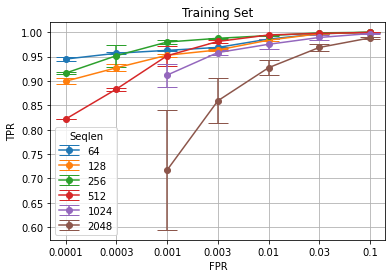

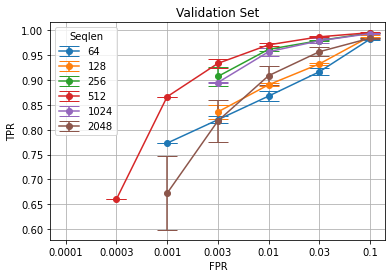

In [4]:
def training_filter(file):
    return file.endswith("training.json")
def validation_filter(file):
    return file.endswith("validation.json")
def key_extractor(file):
    return file.split("_")[0]

metrics_train = {}
metrics_val = {}
for folder in run_folders:
    metrics_train.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, training_filter))
    metrics_val.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, validation_filter))

TITLE = RUN_NAME.capitalize()
newkeys = [x for x in metrics_train.keys()]
ax = plot_cv_metrics_dict(metrics_train, "tpr", legendTitle=TITLE, legendValues=newkeys)
ax.set_title("Training Set")

ax = plot_cv_metrics_dict(metrics_val, "tpr", legendTitle=TITLE, legendValues=newkeys)
_ = ax.set_title("Validation Set")

In [5]:
models = defaultdict(dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for run_type in RUN_TYPES:
    nebula_vocab_file = os.path.join(INFOLDER, f"nebula_vocab_{VOCAB}_seqlen_{run_type}", f"tokenizer_{VOCAB}_vocab.json")

    with open(nebula_vocab_file) as f:
        nebula_vocab = json.load(f)
    models[run_type]['class'] = TransformerEncoderChunks
    models[run_type]['config'] = {
        "vocab_size": len(nebula_vocab),
        "maxlen": run_type,
        "chunk_size": 64,
        "dModel": 64,  # embedding & transformer dimension
        "nHeads": 8,  # number of heads in nn.MultiheadAttention
        "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
        "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        "numClasses": 1, # binary classification
        "hiddenNeurons": [64],
        "layerNorm": False,
        "dropout": 0.3,
        "mean_over_sequence": False,
        "norm_first": True
    }

In [6]:
metrics_val = defaultdict(list)
model_files = defaultdict(list)
for folder in run_folders:
    key = int(folder.split("_")[1])
    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_val_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = []
        print(f"[*] In process: {key}")

        folder = os.path.join(INFOLDER, folder)
        data_splits = read_cv_data_splits(folder)
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]
        
        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                data_splits[i]["X_test"],
                data_splits[i]["y_test"],
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true, y_pred, metrics_full=True)
            metrics.append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_val[key] = metrics

base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(metrics_val)

[*] In process: 64
[*] Running ROC for split: 0
Evaluating 64_split_0 | Size: 3562305...


100%|██████████| 265/265 [00:02<00:00, 124.52it/s]


[*] Running ROC for split: 1
Evaluating 64_split_1 | Size: 3562305...


100%|██████████| 265/265 [00:01<00:00, 211.90it/s]


[*] Running ROC for split: 2
Evaluating 64_split_2 | Size: 3562305...


100%|██████████| 265/265 [00:01<00:00, 208.48it/s]


[*] In process: 128
[*] Running ROC for split: 0
Evaluating 128_split_0 | Size: 3824449...


100%|██████████| 265/265 [00:02<00:00, 120.78it/s]


[*] Running ROC for split: 1
Evaluating 128_split_1 | Size: 3824449...


100%|██████████| 265/265 [00:02<00:00, 123.24it/s]


[*] Running ROC for split: 2
Evaluating 128_split_2 | Size: 3824449...


100%|██████████| 265/265 [00:02<00:00, 123.71it/s]


[*] In process: 256
[*] Running ROC for split: 0
Evaluating 256_split_0 | Size: 4348737...


100%|██████████| 265/265 [00:03<00:00, 67.76it/s]


[*] Running ROC for split: 1
Evaluating 256_split_1 | Size: 4348737...


100%|██████████| 265/265 [00:03<00:00, 66.44it/s]


[*] Running ROC for split: 2
Evaluating 256_split_2 | Size: 4348737...


100%|██████████| 265/265 [00:04<00:00, 65.12it/s]


[*] In process: 512
[*] Running ROC for split: 0
Evaluating 512_split_0 | Size: 5397313...


100%|██████████| 265/265 [00:07<00:00, 34.27it/s]


[*] Running ROC for split: 1
Evaluating 512_split_1 | Size: 5397313...


100%|██████████| 265/265 [00:08<00:00, 32.56it/s]


[*] Running ROC for split: 2
Evaluating 512_split_2 | Size: 5397313...


100%|██████████| 265/265 [00:08<00:00, 30.54it/s]


[*] In process: 1024
[*] Running ROC for split: 0
Evaluating 1024_split_0 | Size: 7494465...


100%|██████████| 265/265 [00:15<00:00, 17.28it/s]


[*] Running ROC for split: 1
Evaluating 1024_split_1 | Size: 7494465...


100%|██████████| 265/265 [00:15<00:00, 16.67it/s]


[*] Running ROC for split: 2
Evaluating 1024_split_2 | Size: 7494465...


100%|██████████| 265/265 [00:16<00:00, 15.84it/s]


[*] In process: 2048
[*] Running ROC for split: 0
Evaluating 2048_split_0 | Size: 11688769...


100%|██████████| 265/265 [00:31<00:00,  8.50it/s]


[*] Running ROC for split: 1
Evaluating 2048_split_1 | Size: 11688769...


100%|██████████| 265/265 [00:32<00:00,  8.19it/s]


[*] Running ROC for split: 2
Evaluating 2048_split_2 | Size: 11688769...


100%|██████████| 265/265 [00:31<00:00,  8.35it/s]


,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC,F1,Recall,Precision,Accuracy
64,0.504877,0.599485,0.754894,0.820333,0.866937,0.916871,0.982351,0.998445,0.991949,0.967720,0.966281,0.969188,0.956428
128,0.479438,0.632753,0.750520,0.840025,0.891840,0.932269,0.988184,0.998659,0.993530,0.971985,0.974133,0.969851,0.962050
256,0.315982,0.528098,0.774010,0.903642,0.962527,0.979690,0.994519,0.998931,0.997078,0.982155,0.982002,0.982309,0.975882
512,0.439234,0.680426,0.855927,0.923753,0.969310,0.986316,0.994927,0.998795,0.997628,0.985802,0.985754,0.985858,0.980808
1024,0.387072,0.562758,0.714056,0.827014,0.910369,0.968235,0.989548,0.998271,0.994909,0.976428,0.985324,0.968000,0.967659
2048,0.230765,0.357774,0.657871,0.781252,0.895494,0.953031,0.982197,0.995821,0.992312,0.971341,0.976967,0.965875,0.960999


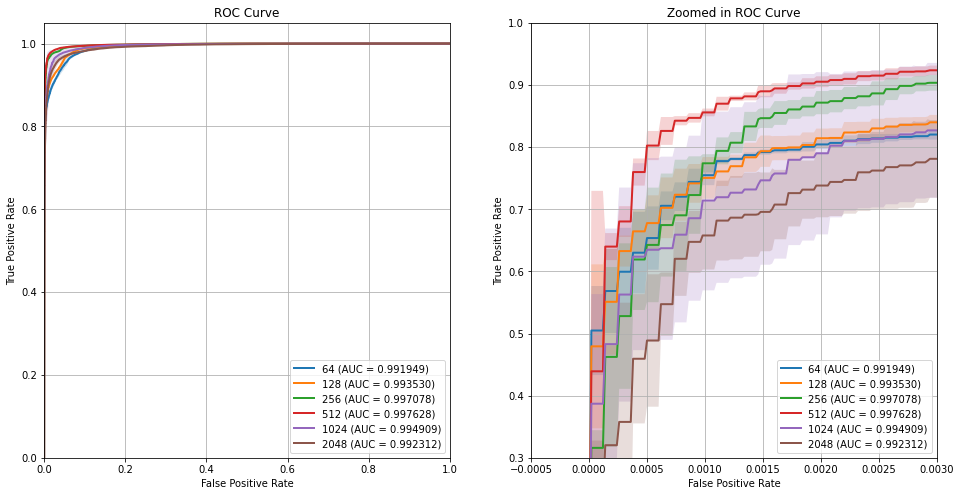

In [7]:
df, axs_val = report_alligned_metrics(
    base_fpr_val,
    tprs_mean_val,
    tprs_std_val,
    metrics_val,
    xlim=[-0.0005, 0.003],
    ylim=[0.3, 1.0],
    metrics_full=True
)
df

## Test set ROCs

In [8]:
model_files = defaultdict(list)
metrics_test = defaultdict(list)
for folder in sorted(run_folders, key = lambda x: int(x.split("_")[1])):
    key = int(folder.split("_")[1])
    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_test_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = []
        print(f"[*] In process: {key}")
        folder = os.path.join(INFOLDER, folder)

        data_folder = [x for x in os.listdir(INFOLDER) if str(key) in x and "vocab" in x][0]
        X_test = np.load(os.path.join(INFOLDER, data_folder, f"x_test_{LIMIT}.npy"))
        y_test = np.load(os.path.join(INFOLDER, data_folder, f"y_test_{LIMIT}.npy"))
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]

        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                X_test,
                y_test,
                model_name=f"{key}_split_{i}",
                batch_size=64
            )
            fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true, y_pred, metrics_full=True)
            metrics.append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_test[key] = metrics

base_fpr_test, tprs_mean_test, tprs_std_test = allign_metrics(metrics_test)

[*] In process: 64
[*] Running ROC for split: 0
Evaluating 64_split_0 | Size: 3562305...


100%|██████████| 272/272 [00:01<00:00, 220.20it/s]


[*] Running ROC for split: 1
Evaluating 64_split_1 | Size: 3562305...


100%|██████████| 272/272 [00:00<00:00, 272.70it/s]


[*] Running ROC for split: 2
Evaluating 64_split_2 | Size: 3562305...


100%|██████████| 272/272 [00:01<00:00, 260.17it/s]


[*] In process: 128
[*] Running ROC for split: 0
Evaluating 128_split_0 | Size: 3824449...


100%|██████████| 272/272 [00:01<00:00, 156.63it/s]


[*] Running ROC for split: 1
Evaluating 128_split_1 | Size: 3824449...


100%|██████████| 272/272 [00:01<00:00, 159.09it/s]


[*] Running ROC for split: 2
Evaluating 128_split_2 | Size: 3824449...


100%|██████████| 272/272 [00:01<00:00, 153.53it/s]


[*] In process: 256
[*] Running ROC for split: 0
Evaluating 256_split_0 | Size: 4348737...


100%|██████████| 272/272 [00:03<00:00, 86.58it/s]


[*] Running ROC for split: 1
Evaluating 256_split_1 | Size: 4348737...


100%|██████████| 272/272 [00:03<00:00, 86.99it/s]


[*] Running ROC for split: 2
Evaluating 256_split_2 | Size: 4348737...


100%|██████████| 272/272 [00:03<00:00, 86.77it/s]


[*] In process: 512
[*] Running ROC for split: 0
Evaluating 512_split_0 | Size: 5397313...


100%|██████████| 272/272 [00:05<00:00, 48.53it/s]


[*] Running ROC for split: 1
Evaluating 512_split_1 | Size: 5397313...


100%|██████████| 272/272 [00:05<00:00, 48.96it/s]


[*] Running ROC for split: 2
Evaluating 512_split_2 | Size: 5397313...


100%|██████████| 272/272 [00:05<00:00, 47.08it/s]


[*] In process: 1024
[*] Running ROC for split: 0
Evaluating 1024_split_0 | Size: 7494465...


100%|██████████| 272/272 [00:11<00:00, 24.51it/s]


[*] Running ROC for split: 1
Evaluating 1024_split_1 | Size: 7494465...


100%|██████████| 272/272 [00:11<00:00, 23.94it/s]


[*] Running ROC for split: 2
Evaluating 1024_split_2 | Size: 7494465...


100%|██████████| 272/272 [00:11<00:00, 22.77it/s]


[*] In process: 2048
[*] Running ROC for split: 0
Evaluating 2048_split_0 | Size: 11688769...


100%|██████████| 272/272 [00:22<00:00, 12.31it/s]


[*] Running ROC for split: 1
Evaluating 2048_split_1 | Size: 11688769...


100%|██████████| 272/272 [00:21<00:00, 12.38it/s]


[*] Running ROC for split: 2
Evaluating 2048_split_2 | Size: 11688769...


100%|██████████| 272/272 [00:22<00:00, 12.04it/s]


,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC,F1,Recall,Precision,Accuracy
64,0.191818,0.246588,0.367400,0.515545,0.623879,0.723422,0.843752,0.960580,0.952942,0.875199,0.846397,0.906943,0.869746
128,0.149420,0.206920,0.376015,0.554362,0.661207,0.747137,0.861073,0.954447,0.954218,0.880369,0.843029,0.921421,0.876352
256,0.224396,0.333298,0.452976,0.627530,0.767025,0.825375,0.888227,0.949945,0.958369,0.901642,0.866603,0.939670,0.897838
512,0.354958,0.436775,0.563614,0.692297,0.793506,0.861711,0.919636,0.964380,0.971475,0.915304,0.872771,0.962334,0.912736
1024,0.177993,0.280442,0.373711,0.549683,0.728881,0.845156,0.904520,0.955865,0.963323,0.909141,0.872594,0.949537,0.905651
2048,0.135985,0.254103,0.358503,0.491829,0.633911,0.772023,0.875678,0.944060,0.949940,0.895160,0.872488,0.919464,0.889412


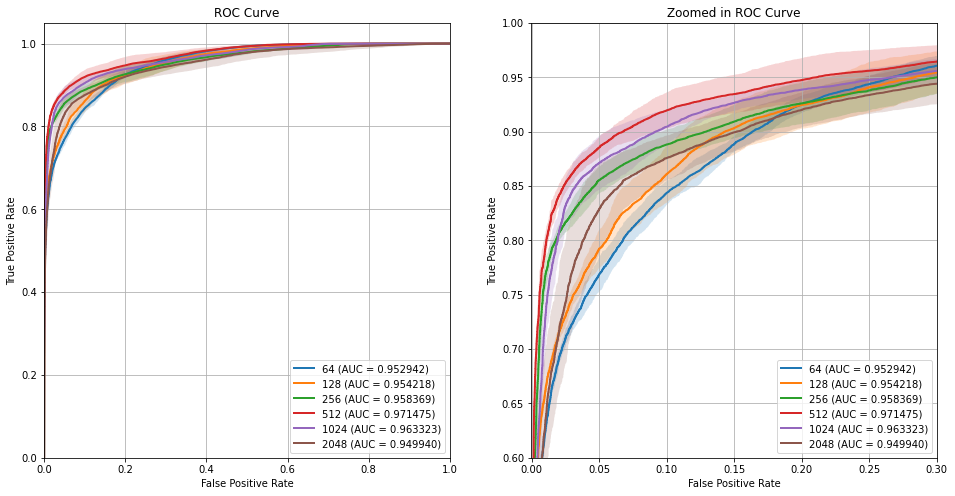

In [9]:
df, axs_test = report_alligned_metrics(
    base_fpr_test,
    tprs_mean_test,
    tprs_std_test,
    metrics_test,
    metrics_full=True
)
df

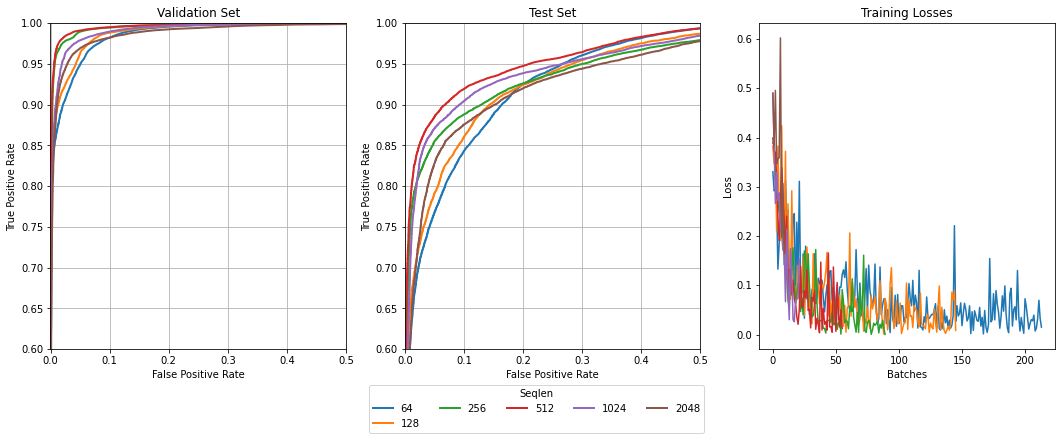

In [12]:
import matplotlib.pyplot as plt

YLIM = [0.6, 1]
XLIM = [-0.0005, 0.5]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for key in tprs_mean_val:
    if key == 0.01:
        continue
    plot_roc_curve(base_fpr_val, tprs_mean_val[key], model_name=key, ax=axs[0], ylim=YLIM, xlim=XLIM)
    plot_roc_curve(base_fpr_test, tprs_mean_test[key], model_name=key, ax=axs[1], ylim=YLIM, xlim=XLIM)

axs[0].set_title("Validation Set")
axs[1].set_title("Test Set")
#[ax.legend(loc="lower right", title="Learning rate") for ax in axs[0:2]]
[ax.set_ylabel("True Positive Rate") for ax in axs[0:2]]
[ax.set_xlabel("False Positive Rate") for ax in axs[0:2]]
[ax.grid() for ax in axs[0:2]]

start = 100
n = 70
for folder in run_folders:
    key = folder.split("_")[1]
    train_folder = os.path.join(INFOLDER, folder, "training_files")
    train_losses = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if "trainLosses" in x][0]
    loss_mean = np.load(train_losses)[start::n]    
    axs[2].plot(loss_mean, label=key)
axs[2].set_xlabel("Batches")
axs[2].set_ylabel("Loss")
axs[2].set_title("Training Losses")

# make one common legend below the plots so it does not overlap with the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, title=RUN_NAME.capitalize(), bbox_to_anchor=(0.5, -0.08))

_ = fig.savefig(os.path.join(REPO_ROOT, "img", f"results_{'_'.join(RUN_NAME.split(' '))}.png"), dpi=300, bbox_inches='tight')